In [1]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
im = Image.open('png/CXR1_1_IM-0001-3001.png')

In [5]:
print(type(im))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [6]:
def plot_results(pil_img):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img,cmap='gray')
    plt.axis('off')
    plt.show()

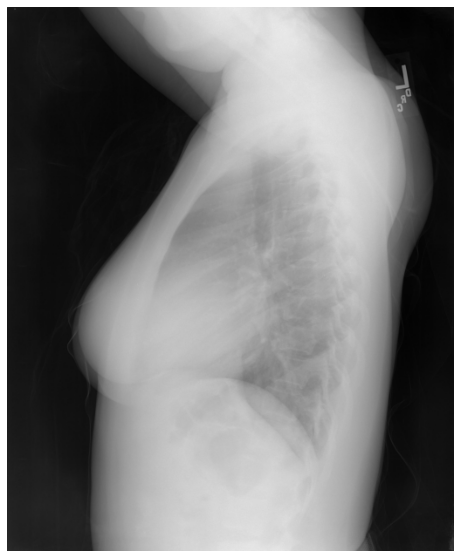

In [7]:
plot_results(im)

In [34]:
def detect(img, transform):
    img = transform(im).unsqueeze(0)
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
    return img

In [57]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [58]:
print(detect(im, transform).shape)

torch.Size([1, 3, 975, 800])


In [59]:
import numpy as np

In [60]:
import torch.nn as nn

In [61]:
from torchvision.models import resnet50
self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])

In [87]:
class SimpleDETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=384, nheads=4,
                 num_encoder_layers=3, num_decoder_layers=3):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)


        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        
    def forward(self, X):
        X = self.backbone(X)
        h = self.conv(X)
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        return h

In [95]:
#LSP decoder
decoder_layer = nn.TransformerDecoderLayer(d_model=384, nhead=4)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)

In [88]:
model=SimpleDETR(3000)

In [96]:
model2=transformer_decoder

In [89]:
from torchsummary import summary

In [90]:
pre_im=np.array(detect(im, transform))

In [91]:
pre_im.shape

(1, 3, 975, 800)

In [92]:
import torch

In [93]:
out=model(torch.tensor(pre_im))

In [94]:
print(out.shape)

torch.Size([1, 100, 384])


In [105]:
N,c=10,384
emb = nn.Embedding(N, c)
x = torch.arange(N)
x = emb(x).unsqueeze(0)

y=model2(x,out)

In [106]:
print(x.shape)

torch.Size([1, 10, 384])


In [107]:
print(out.shape)

torch.Size([1, 100, 384])


In [108]:
print(y.shape)

torch.Size([1, 10, 384])


In [112]:
torch.save(y, 'test.tsv')

In [113]:
from tensorboard.plugins import projector

In [117]:
log_dir='logs/'

In [118]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

In [119]:
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'test.tsv'
projector.visualize_embeddings(log_dir, config)

In [120]:
from torch.utils.tensorboard import SummaryWriter

In [121]:
writer = SummaryWriter()

In [122]:
l = [i for i in range(10)]

In [131]:
writer.add_embedding(y.reshape((10,384)))
writer.close()

In [128]:
torch.randn(100, 5).shape

torch.Size([100, 5])

In [130]:
y.reshape((10,384)).shape

torch.Size([10, 384])

In [133]:
from scipy.optimize import linear_sum_assignment

In [156]:
from sentence_transformers import SentenceTransformer
model3 = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.',
            'Hello bro',
            'I need coffy',
            'This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.',
            'hello bro',
            'i need coffy']*10

#Sentences are encoded by calling model.encode()
sentence_embeddings = model3.encode(sentences)

In [157]:
np_out = out.reshape((100,384)).detach().numpy()

In [158]:
from scipy.spatial import distance_matrix

In [159]:
print(sentence_embeddings.shape)
print(np_out.shape)

(100, 384)
(100, 384)


In [160]:
d=distance_matrix(sentence_embeddings,np_out)

In [161]:
row_ind, col_ind = linear_sum_assignment(d)

In [162]:
print(col_ind)

[37 39 75 14 66  8 77 60 12  7 54 25 21 93 79 44 70 71 36 15 52 29 31  6
 55 94 78  5 45 69 80 74 97 62 61 90 17 27 72 46 16 13 58 57 82 85  0 84
 38 51 64 56 33 22 53 81 35 30 96 86  3  2  1 83 49 40 99 91 88 59 67 92
 41 50 68 73 24  9 10 95 76 65 26 23 47 87 11 18 63 34  4 98 28 43 42 20
 19 48 32 89]


In [163]:
print(len(col_ind))

100


In [164]:
row=np.arange(len(col_ind))
print(row)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [165]:
a = np.zeros((len(col_ind), len(col_ind)))
a[row, col_ind] = 1

In [169]:
ch=torch.Tensor(a)

In [171]:
print(ch.shape)
print(out.shape)

torch.Size([100, 100])
torch.Size([1, 100, 384])


In [173]:
mm=torch.matmul(ch.unsqueeze(1), out)

In [ ]:
sentence_embeddings